<center>
    <h1>Fault Tree Analysis with Storm</h1>
    <h2>Sebastian Junges</h2>
    <h3>Based on material by Matthias Volk</h3>
    <br>
<img src="attachment:storm_logo.png" width="500px"/></center>

**<center>[www.stormchecker.org](https://www.stormchecker.org)</center>**

<div align="right">Press <em>spacebar</em> to navigate</div>

## Dynamic Fault Tree (DFT)

![hecs](examples/hecs.png)

The DFT models a Hypothetical Computer System (HECS).

In [17]:
import stormpy
import stormpy.dft

# Load DFT from file
dft = stormpy.dft.load_dft_galileo_file("examples/hecs.dft")
print("Loaded DFT with {} elements, {} BEs and {} dynamic elements.".format(dft.nr_elements(), dft.nr_be(), dft.nr_dynamic()))
dft = stormpy.dft.prepare_for_analysis(dft)

Loaded DFT with 19 elements, 12 BEs and 2 dynamic elements.


## Interactively simulating a DFT


![hecs](examples/hecs.png)

With some helper functions hidden below, we can create a simulator.

In [12]:
def get_simulator(dft, seed=42):
    # Compute all symmetries
    symmetries = dft.symmetries()
    # Set only top event as relevant
    relevant_events = stormpy.dft.compute_relevant_events(dft, [])
    dft.set_relevant_events(relevant_events, False)
    # Create information for state space generation
    info = dft.state_generation_info(symmetries)
    # Initialize random generator
    generator = stormpy.dft.RandomGenerator.create(seed)
    # Create simulator
    return stormpy.dft.DFTSimulator_double(dft, info, generator)


def get_status(state, dft):
    if state.invalid():
        return "State is invalid because a SEQ is violated"
    state_tle = state.failed(dft.top_level_element.id)
    s = "DFT is {}".format("Failed" if state_tle else "Operational")
    for i in range(dft.nr_elements()):
        # Order of checks is important!
        if state.operational(i):
            status = "Operational"
        elif state.dontcare(i):
            status = "Don't Care"
        elif state.failsafe(i):
            status = "FailSafe"
        elif state.failed(i):
            status = "Failed"
        else:
            status = "Unknown"
        elem = dft.get_element(i)
        if elem.type == stormpy.dft.DFTElementType.SPARE:
            cur_used = state.spare_uses(i)
            if cur_used == i:
                status += ", not using anything"
            else:
                elem_used = dft.get_element(cur_used)
                status += ", currently using {}".format(elem_used.name)
        s += "\n{0: <11}: {1}".format(elem.name, status)
    return s

def get_failables(state, dft):
    failables = dict()
    for f in state.failable():
        fail_be = f.get_fail_be_double(dft)
        failables[fail_be[0].name] = f
    return failables


In [14]:
# Create simulator
simulator = get_simulator(dft, seed=42)

# Get initial state
state = simulator.current()
print("Initial status: {}".format(get_status(state, dft)))

Initial status: DFT is Operational
P_1        : Operational
P_S        : Operational
Proc_1     : Operational, currently using P_1
P_2        : Operational
Proc_2     : Operational, currently using P_2
Processors : Operational
M_1        : Operational
M_2        : Operational
M_3        : Operational
M_4        : Operational
M_5        : Operational
Memory     : Operational
B_1        : Operational
B_2        : Operational
Bus        : Operational
HW         : Operational
SW         : Operational
Interface  : Operational
System     : Operational


## Interactively simulating a DFT


![hecs](examples/hecs.png)

In [6]:
failables = get_failables(state, dft)
print("Basic events which can fail: {}".format(failables.keys()))

Basic events which can fail: dict_keys(['P_1', 'P_2', 'M_1', 'M_2', 'M_3', 'M_4', 'M_5', 'B_1', 'B_2', 'HW', 'SW'])


In [8]:
# Let P_1 fail
chosen = "P_1"
res = simulator.step(failables[chosen])
print("Status {}:".format(get_status(simulator.current(), dft)))

Status DFT is Operational
P_1        : Failed
P_S        : Operational
Proc_1     : Operational, currently using P_S
P_2        : Operational
Proc_2     : Operational, currently using P_2
Processors : Operational
M_1        : Operational
M_2        : Operational
M_3        : Operational
M_4        : Operational
M_5        : Operational
Memory     : Operational
B_1        : Operational
B_2        : Operational
Bus        : Operational
HW         : Operational
SW         : Operational
Interface  : Operational
System     : Operational:


## Interactively simulating a DFT


![hecs](examples/hecs.png)

In [6]:
failables = get_failables(state, dft)
print("Basic events which can fail: {}".format(failables.keys()))

Basic events which can fail: dict_keys(['P_1', 'P_2', 'M_1', 'M_2', 'M_3', 'M_4', 'M_5', 'B_1', 'B_2', 'HW', 'SW'])


In [7]:
# Let SW fail
chosen = "SW"
res = simulator.step(failables[chosen])
print("Status {}:".format(get_status(simulator.current(), dft)))

Status DFT is Failed
P_1        : Failed
P_S        : Operational
Proc_1     : Operational, currently using P_S
P_2        : Operational
Proc_2     : Operational, currently using P_2
Processors : Don't Care
M_1        : Don't Care
M_2        : Don't Care
M_3        : Don't Care
M_4        : Don't Care
M_5        : Don't Care
Memory     : Don't Care
B_1        : Don't Care
B_2        : Don't Care
Bus        : Don't Care
HW         : Don't Care
SW         : Don't Care
Interface  : Don't Care
System     : Failed:


## DFT Analysis via Model Checking

![hecs](examples/hecs.png)

In [9]:
# Compute mean-time-to-failure (MTTF
prop_mttf = stormpy.parse_properties('T=? [ F "failed" ]')[0]
results = stormpy.dft.analyze_dft(dft, [prop_mttf.raw_formula])
print("MTTF: {:.2f}".format(results[0]))

MTTF: 5737.44


## DFT Analysis via Model Checking

In [10]:
# Build Markov model
model = stormpy.dft.build_model(dft, dft.symmetries())
# Analyse Markov model
results = [] 
for time in range(0, 10000, 100):
    formulas = stormpy.parse_properties('P=? [ F<={} "failed" ]'.format(time))
    results.append(stormpy.model_checking(model, formulas[0]).at(model.initial_states[0]))
    

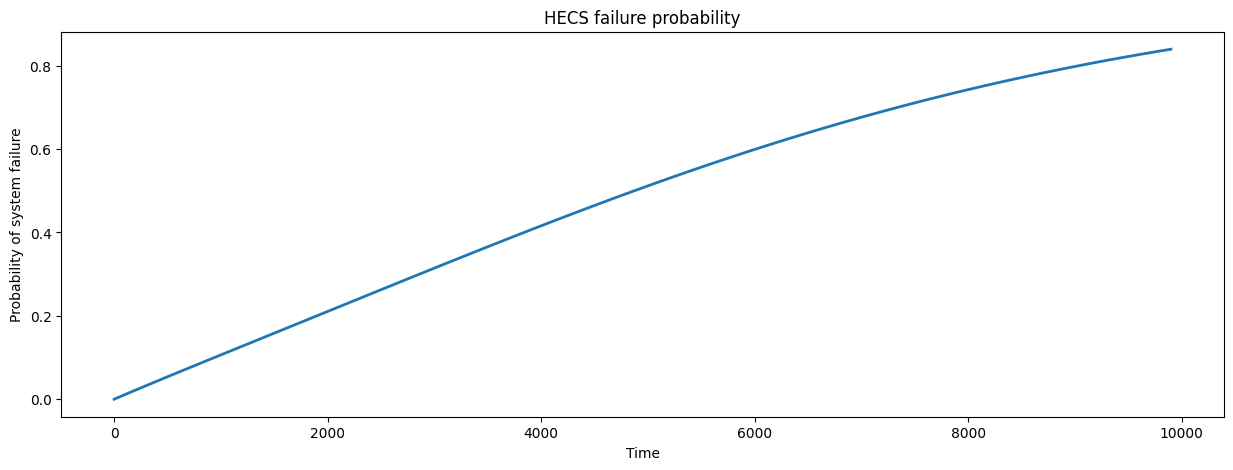

In [11]:
# Plot
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.xlabel('Time')
plt.ylabel('Probability of system failure')
plt.title('HECS failure probability')
plt.plot(range(0, 10000, 100), results, linewidth=2)

## Approximate analysis by building partial state space

In [11]:
def iteration(builder, i, prop):
    builder.build(i, 1.0)
    model_low = builder.get_partial_model(True, True)
    result_low = stormpy.model_checking(model_low, prop).at(model_low.initial_states[0])
    model_up = builder.get_partial_model(False, True)
    result_up = stormpy.model_checking(model_up, prop).at(model_up.initial_states[0])
    return result_low, result_up, model_low.nr_states

In [12]:
no_iterations = 4
prop = stormpy.parse_properties('P=? [ F<=5000 "failed" ]')[0]

builder = stormpy.dft.ExplicitDFTModelBuilder_double(dft, dft.symmetries())
results_low, results_up, states = [], [], []
for i in range(0, no_iterations+1):
    res_low, res_up, state = iteration(builder, i, prop)
    results_low.append(res_low)
    results_up.append(res_up)
    states.append(state)

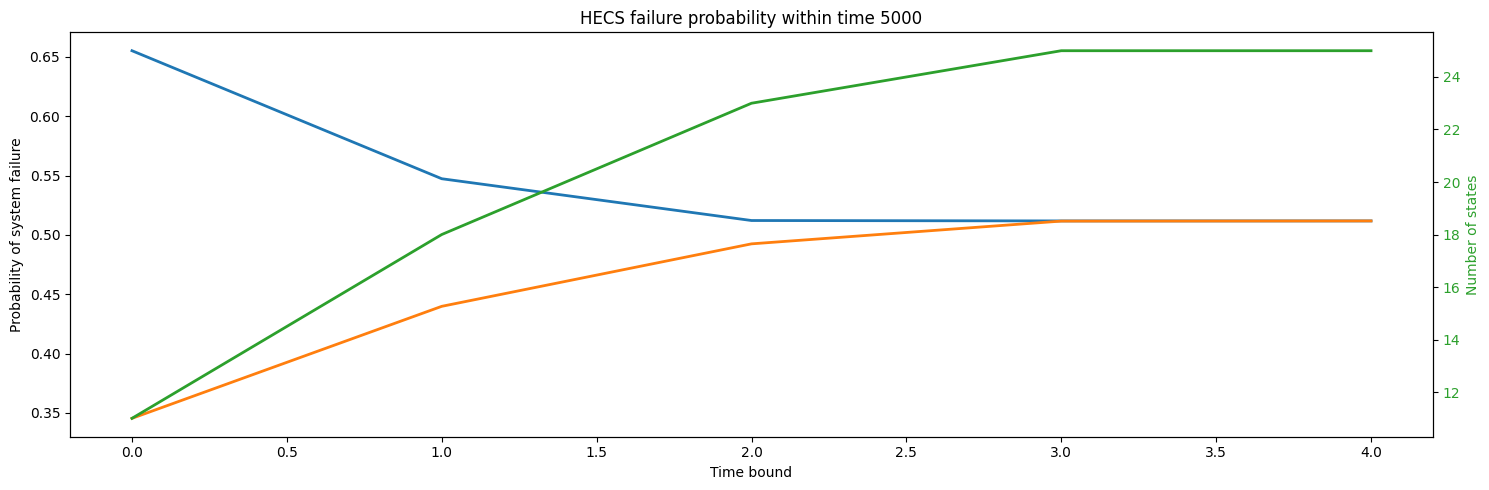

In [13]:
# Plot
fig, ax1 = plt.subplots()
plt.rcParams["figure.figsize"] = (15,5)
plt.title('HECS failure probability within time 5000')
ax1.set_xlabel('Time bound')
ax1.set_ylabel('Probability of system failure')
ax1.plot(range(0, no_iterations+1), results_low, linewidth=2, label='lower bound')
ax1.plot(range(0, no_iterations+1), results_up, linewidth=2, label='upper bound')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Number of states', color=color)
ax2.plot(range(0, no_iterations+1), states, linewidth=2, color=color, label='number of states')
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()